# LSTM  + ElMO



In [1]:
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
import random
import torch

torch.manual_seed(2019)
np.random.seed(2019)
tf.random.set_random_seed(2019)
random.seed(2019)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_test = pd.read_table("../../../data/es/reference_es.tsv", header=None, 
                        names=["text", "HS", "TR", "AG"], quoting=csv.QUOTE_NONE)


text_train, y_train = df_train["text"], df_train["HS"]
text_dev, y_dev = df_dev["text"], df_dev["HS"]
text_test, y_test = df_test["text"], df_test["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))


Instancias de entrenamiento: 4500
Instancias de desarrollo: 500


Tengo que hacer dos cosas:

- Primero, convertir los tweets a secuencias de texto
- Luego, paddear las secuencias a cierta longitud (Keras necesita esto para poder paralelizar cálculo)

In [2]:
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.sequence import pad_sequences


max_length = 30

tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

def preprocess_tweet(tweet):
    tokens = tokenizer.tokenize(tweet)
    
    if len(tokens) >= max_length:
        tokens = tokens[:max_length]
    else:
        tokens = tokens + [''] * (max_length - len(tokens))
    return tokens


text_train = [preprocess_tweet(tweet) for tweet in df_train["text"].values]
text_dev = [preprocess_tweet(tweet) for tweet in df_dev["text"].values]
text_test = [preprocess_tweet(tweet) for tweet in df_test["text"].values]

Using TensorFlow backend.


In [3]:
%%capture
from elmoformanylangs import Embedder

e = Embedder("../../../models/elmo/es/")

Carguemos embeddings

In [4]:
import numpy as np

print(text_train[0])


X_train = np.array(e.sents2elmo(text_train))
X_dev = np.array(e.sents2elmo(text_dev))
X_test = np.array(e.sents2elmo(text_test))

['easyjet', 'quiere', 'duplicar', 'el', 'número', 'de', 'mujeres', 'piloto', "'", 'verás', 'tú', 'para', 'aparcar', 'el', 'avión', '..', 'http://t.co/46NuLkm09x', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [5]:
X_train.shape, X_dev.shape, X_test.shape, y_train.shape, y_dev.shape, y_test.shape

((4500, 30, 1024), (500, 30, 1024), (1600, 30, 1024), (4500,), (500,), (1600,))

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras.preprocessing import sequence

embedding_dim = 1024

optimizer_args = {
    "lr": 0.0005,
    "decay": 0.01
}

model = Sequential()
model.add(CuDNNLSTM(256, input_shape=(max_length, embedding_dim)))
model.add(Dropout(0.75))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=28, batch_size=32)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               1312768   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 1,378,817
Trainable params: 1,378,817
Non-trainable params: 0
_________________________________________________________________
None
Train on 4500 samples, validate on 500 samples
Epoch 1/28
4500/4500 [==============================] - 3s 703us/step - loss: 0.

In [7]:
from hate.utils import print_evaluation

print("Evaluación sobre dev")
print_evaluation(model, X_dev, y_dev)
print("\n\nEvaluación sobre test")
print_evaluation(model, X_test, y_test)



Evaluación sobre dev
500/500 [==============================] - 0s 182us/step
Loss           : 0.4577
Accuracy       : 0.7880
Precision(1)   : 0.7843
Precision(1)   : 0.7905
Precision(avg) : 0.7874

Recall(1)      : 0.7207
Recall(0)      : 0.8417
Recall(avg)    : 0.7812

F1(1)          : 0.7512
F1(0)          : 0.8153
F1(avg)        : 0.7833


Evaluación sobre test
1600/1600 [==============================] - 0s 170us/step
Loss           : 0.6080
Accuracy       : 0.7181
Precision(1)   : 0.6530
Precision(1)   : 0.7666
Precision(avg) : 0.7098

Recall(1)      : 0.6758
Recall(0)      : 0.7479
Recall(avg)    : 0.7118

F1(1)          : 0.6642
F1(0)          : 0.7571
F1(avg)        : 0.7107


## Bidirectional GRU

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import CuDNNGRU, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import Adam

optimizer_args = {
    "lr": 0.0005,
    "decay": 0.01
}

embedding_dim = 1024

model = Sequential()
model.add(Bidirectional(CuDNNGRU(256), input_shape=(max_length, embedding_dim)))
model.add(Dropout(0.80))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.55))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

model.fit(X_train, y_train.values, validation_data=(X_dev, y_dev), epochs=35, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/35
4500/4500 [==============================] - 3s 580us/step - loss: 0.8301 - acc: 0.5471 - val_loss: 0.6550 - val_acc: 0.6340
Epoch 2/35
4500/4500 [==============================] - 2s 435us/step - loss: 0.7146 - acc: 0.5949 - val_loss: 0.6507 - val_acc: 0.6340
Epoch 3/35
4500/4500 [==============================] - 2s 440us/step - loss: 0.6782 - acc: 0.6193 - val_loss: 0.6403 - val_acc: 0.6660
Epoch 4/35
4500/4500 [==============================] - 2s 441us/step - loss: 0.6513 - acc: 0.6389 - val_loss: 0.6284 - val_acc: 0.6620
Epoch 5/35
4500/4500 [==============================] - 2s 443us/step - loss: 0.6284 - acc: 0.6562 - val_loss: 0.6175 - val_acc: 0.6640
Epoch 6/35
4500/4500 [==============================] - 2s 439us/step - loss: 0.5995 - acc: 0.6847 - val_loss: 0.6022 - val_acc: 0.6740
Epoch 7/35
4500/4500 [==============================] - 2s 440us/step - loss: 0.5982 - acc: 0.6853 - val_loss: 0.5884 - val_acc: 0.6940
E

## Average Pooling

In [73]:
from keras.layers import Dense, Lambda, Flatten

optimizer_args = {
    "lr": 0.003,
    "decay": 0.00
}

embedding_dim = 1024

model = Sequential()

model.add(AveragePooling1D(pool_size=max_length, input_shape=(max_length, embedding_dim)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])




In [74]:
model.fit(X_train, y_train.values, validation_data=(X_dev, y_dev), epochs=100, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 3s 717us/step - loss: 0.6476 - acc: 0.6289 - val_loss: 0.6332 - val_acc: 0.6220
Epoch 2/100
4500/4500 [==============================] - 1s 207us/step - loss: 0.6111 - acc: 0.6740 - val_loss: 0.5975 - val_acc: 0.6820
Epoch 3/100
4500/4500 [==============================] - 1s 207us/step - loss: 0.6019 - acc: 0.6707 - val_loss: 0.5859 - val_acc: 0.6880
Epoch 4/100
4500/4500 [==============================] - 1s 207us/step - loss: 0.5935 - acc: 0.6818 - val_loss: 0.5699 - val_acc: 0.7000
Epoch 5/100
4500/4500 [==============================] - 1s 210us/step - loss: 0.5790 - acc: 0.6962 - val_loss: 0.5636 - val_acc: 0.7140
Epoch 6/100
4500/4500 [==============================] - 1s 211us/step - loss: 0.5785 - acc: 0.6936 - val_loss: 0.5659 - val_acc: 0.7080
Epoch 7/100
4500/4500 [==============================] - 1s 208us/step - loss: 0.5751 - acc: 0.6989 - val_loss: 0.5578 - val_acc: 0

KeyboardInterrupt: 

In [75]:
from hate.utils import print_evaluation

print("Evaluación sobre dev")
print_evaluation(model, X_dev, y_dev)
print("\n\nEvaluación sobre test")
print_evaluation(model, X_test, y_test)


Evaluación sobre dev
500/500 [==============================] - 0s 161us/step
Loss           : 0.5472
Accuracy       : 0.7240
Precision(1)   : 0.7658
Precision(1)   : 0.7047
Precision(avg) : 0.7353

Recall(1)      : 0.5450
Recall(0)      : 0.8669
Recall(avg)    : 0.7060

F1(1)          : 0.6368
F1(0)          : 0.7774
F1(avg)        : 0.7071


Evaluación sobre test
1600/1600 [==============================] - 0s 131us/step
Loss           : 0.6222
Accuracy       : 0.6556
Precision(1)   : 0.5986
Precision(1)   : 0.6858
Precision(avg) : 0.6422

Recall(1)      : 0.5015
Recall(0)      : 0.7638
Recall(avg)    : 0.6327

F1(1)          : 0.5458
F1(0)          : 0.7227
F1(avg)        : 0.6342


## Error Analysis

Vamos a ver los tweets con mayores errores

In [21]:
df_dev["proba"] = model.predict_proba(X_dev)


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

conf_matrix[["pred_true", "pred_false"]]

,pred_true,pred_false
real,,
hs=1,175,47
hs=0,53,225


## Falsos Negativos

Veamos los 20 falsos negativos en los cuales nuestro modelo se equivoca más

In [29]:
false_negatives.iloc[:20]


,text,HS,TR,AG,proba
id,,,,,
21535,#VOX critica duramente a ⁦@pablocasado_⁩ “Les da la bienvenida como si fuera un cartel del welcome de #Carmena “ ¡Expulsión inmediata de moromierdas! https://t.co/HaySDibj2l,1,0,1,0.043542
21152,@NatyBurgos15 @Horaciogenta @PaolaPa05 Cállate vos Black and bitch como la puta falsa abogada. Espero se pudra en la cárcel y devuelva todo. Dedícate a estudiar en serio. La droga es mala. Cristin...,1,1,1,0.053808
22560,@CarlaEUrena @FelipeCalderon Callateeeee !! Puta gallina cacarea !! Ni idea tienes de nada .,1,1,1,0.080199
23415,Exacto! #puralata #feminazis #HombreAbusado https://t.co/zTEvaftxcd,1,0,1,0.084722
21215,"Que tal otro aporte anónimo son de la puta de mi esposa, así los dejó en navidad enseñando le los calzones al vecino rt y siguenos @TANGASUCIA @Tangasrobadas https://t.co/70ioUjveqY",1,1,1,0.092792
24925,"La verdad que si, no veia la hora de llegar a los 5 mil amigos😂 ahora de a poco voy borrando esos indios indocumentados😂 https://t.co/Xw8q4GLM8v",1,0,0,0.144993
24401,No habrá que darles de lo 'nuestro'. Ellos se apropiarán de lo 'suyo'. @Manuj_Hidalgo les dice ☝️ a quienes piensan q hay q jubilar a los mayores para q trabajen los jóvenes o q los q vienen d fu...,1,0,1,0.151047
21072,"Voy andando por la calle y me han dicho cosas en árabe ya que me estas acosando dime lo en español para que te entienda, asique como yo no les entiendo me he cagado en su puta madre en árabe para ...",1,0,1,0.152465
24590,"SOMOS MUCHO MÁS DE LO QUE SUEÑAS SER PINCHÉ SUDACA CAGADO, y si no te gusta dime donde nos topamos pa reventarnos el hocico 1:1 @amarchesin1 https://t.co/vHHPBKS1AK",1,1,1,0.157015


- Qué onda la longitud de la secuencia?


(array([ 734., 1109., 1019.,  655.,  386.,  315.,  210.,   57.,   13.,
           2.]),
 array([ 2., 10., 18., 26., 34., 42., 50., 58., 66., 74., 82.]),
 <a list of 10 Patch objects>)

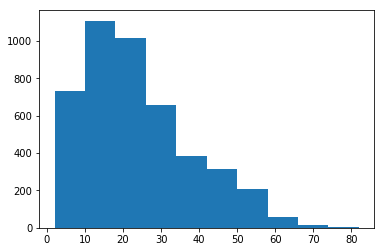

In [39]:
import matplotlib.pyplot as plt

tokens_dev = df_dev["text"].apply(lambda t: len(tokenizer.tokenize(t)))
tokens_train = df_train["text"].apply(lambda t: len(tokenizer.tokenize(t)))

plt.hist(tokens_train)

In [28]:
pd.set_option('max_colwidth', 200)
false_positives.iloc[:20]

,text,HS,TR,AG,proba
id,,,,,
22517,"-¿eres poblana? -soy colombiana -¿y por qué eres güera? en Colombia TODAS son morenas, fui a Colombia 3 veces. -ok, mentí 🙄 solo me pinto el cabello",0,0,0,0.971048
22416,@Pepe_ElEzequiel Puta!? Puta con las que vos te metes Esa mujer es un ángel enviado por Jesucristo nuestro señor para darnos esa paz que buscamos sólo con verla,0,0,0,0.967200
21892,@saancisco Callate puta tu eres el traidor.,0,0,0,0.963039
21497,Talvez quede como zorra pero te lo mereces Socia😎,0,0,0,0.947185
24172,"Y los que no se denuncian... hagamos números. El acoso a las mujeres es diario. No todos los hombres son acosadores, pero todas las mujeres han sido acosadas. https://t.co/jza9llhqWA",0,0,0,0.945128
21255,Y tú eres una maldita escoria con una repugnante inclinación por los hombres.. ¡Seres como tú me producen náuseas! https://t.co/TaHDcpZdnm,0,0,0,0.943286
24159,"@LeonDeJapon Jajajajajaja tu eres uno, diego jajajajajaja mentira perra perra perrraaaaaaaaaa de mierda jajaja ♡",0,0,0,0.931898
24402,zorra eres tu que no te sientes hombre y no entiendes que toda mujer es bella,0,0,0,0.925799
21671,"@danlntifada @fatinascidi @manolivizoso @Zurine3 @Jvillaver2 https://t.co/HG4ljNlwR3, coño entonces tu eres de lo que te guias por el antes de cristo y despues de cristo,cuando llegamos los Españo...",0,0,0,0.921038


['easyjet',
 'quiere',
 'duplicar',
 'el',
 'número',
 'de',
 'mujeres',
 'piloto',
 "'",
 'verás',
 'tú',
 'para',
 'aparcar',
 'el',
 'avión',
 '..',
 'http://t.co/46NuLkm09x',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']